# Table of contents


* [Imports, data reading and descriptive analysis](#imp)
    * [Missing values imputation](#miss)

* [Best model selection (TS CV)](#best)
    * ["Complete" time series](#comp)
    * ["Short" time series](#short)

* [Forecasting and conclusions](#forecast)

## Imports, data reading and descriptive analysis <a class="anchor" id="imp"></a>

In [1]:
import numpy as np
import pandas as pd

import datetime

import seaborn as sns
import matplotlib.pyplot as plt

from tqdm import tqdm

In [2]:
from ts_cv import ts_cv_metrics
from wrappers import WrapperAutoArima, WrapperProphet, WrapperHoltWinters

In [3]:
df = pd.read_csv('train.csv')
df['dt'] = pd.to_datetime(df['dt'])
df.columns = ['id', 'ds', 'y']
df_agg = df.groupby('id').agg({'ds': ['min', 'max', 'count'], 'y': ['mean', 'std']}).reset_index()
df_agg

id         ds                             y            
              min        max count         mean         std
0    0 2016-01-02 2017-06-30   453   776.880353  192.248316
1    1 2016-01-02 2017-06-30   453   485.492274  122.866411
2    2 2016-01-02 2017-06-30   448   595.209598  108.123227
3    3 2016-01-02 2017-06-30   448   435.170982  148.888847
4    4 2016-01-02 2017-06-30   294   385.991156   54.456945
5    5 2016-01-02 2017-06-30   451   454.067849  109.136251
6    6 2016-01-02 2017-06-30   451   640.762749  166.423599
7    7 2016-01-02 2017-06-30   450   634.192000  115.375308
8    8 2016-01-02 2017-06-30   294  1549.520748  297.530101
9    9 2016-01-02 2017-06-30   451   779.500443  184.243248
10  10 2016-01-02 2017-06-30   294   675.758163  104.065112
11  11 2016-01-02 2017-06-30   452   513.794027  135.294493
12  12 2016-01-02 2017-06-30   450   776.747111  283.941149
13  13 2016-01-02 2017-06-30   294   687.877211  128.385238
14  14 2016-01-02 2017-06-30   450   606.364222  177.961598
15  15 2016-01-02 2017-06-30   453   807.902428  180.486750
16  16 2016-01-02 2017-06-30   451   446.958980   97.033838
17  17 2016-01-02 2017-06-30   294   484.503741  147.873661
18  18 2016-01-02 2017-06-30   448   646.840625  177.672308
19  19 2016-01-02 2017-06-30   451   453.589135  135.575430

There are three groups of TS: 
* almost complete TS with 448-452 observations
* 'complete' TS with 453 observations
* short TS with less then 294 observations
    
The interesting thing is that start and end dates are the same of all of the TS, but the amount of days does not suit even the compltete TS so let's investigate further.

In [4]:
df['day'] = df['ds'].dt.dayofweek
df['mnth'] = df['ds'].apply(lambda x: x.replace(day=1))
# number of days of week (0 - Sunday, 1 - Monday, etc.) for each store
df.pivot_table(values='y', index='id', columns='day',aggfunc='count').reset_index()

day,id,0,1,2,3,4,5,6
0,0,72,70,8,74,78,78,73
1,1,72,70,8,74,78,78,73
2,2,72,69,8,72,78,78,71
3,3,72,69,8,72,78,78,71
4,4,48,44,7,48,50,51,46
5,5,72,70,8,74,78,78,71
6,6,72,70,8,74,78,78,71
7,7,72,69,8,74,78,78,71
8,8,48,44,7,48,50,51,46
9,9,72,70,8,74,78,78,71


In [5]:
pivot_df = df.pivot_table(values='y', index=['id', 'mnth'], columns='day', aggfunc='count')
pivot_df = pivot_df.reset_index()
pivot_df.groupby('mnth').min().reset_index()

day,mnth,id,0,1,2,3,4,5,6
0,2016-01-01,0,4.0,NaN,3.0,4.0,4.0,5.0,5.0
1,2016-02-01,0,4.0,NaN,4.0,4.0,4.0,4.0,4.0
2,2016-03-01,0,4.0,5.0,NaN,4.0,4.0,4.0,4.0
3,2016-04-01,0,3.0,4.0,NaN,3.0,5.0,5.0,4.0
4,2016-05-01,0,5.0,5.0,NaN,4.0,4.0,4.0,3.0
5,2016-06-01,0,4.0,4.0,NaN,4.0,4.0,4.0,3.0
6,2016-07-01,0,4.0,4.0,NaN,4.0,5.0,5.0,5.0
7,2016-08-01,0,5.0,5.0,NaN,4.0,4.0,4.0,4.0
8,2016-09-01,0,4.0,4.0,NaN,5.0,5.0,4.0,4.0
9,2016-10-01,0,3.0,4.0,NaN,4.0,4.0,5.0,5.0


Lets exclude from consideration 01 and 02 months of 2016 as irrelevant becaue of different schedule of days off. Also let's impute missing dates.

In [6]:
df = df[df['ds'] >= pd.to_datetime('2016-03-01')]

dates_list = pd.date_range(df['ds'].min(), df['ds'].max())
dates_list = dates_list[dates_list.weekday != 2]  # exclude second day of week (day off)

tmp_dict = pd.DataFrame(dates_list).copy()
tmp_dict.columns = ['ds']
for ts in range(len(np.unique(df['id']))):
    tmp_dict['id'] = ts
    df = pd.merge(df, tmp_dict, how='outer')

df = df.sort_values(['id', 'ds'])

df['day'] = df['ds'].dt.dayofweek  # day of week
df['mnth'] = df['ds'].apply(lambda x: x.replace(day=1))  # month
df = df.reset_index(drop=True)
df

,id,ds,y,day,mnth
0,0,2016-03-01,564.2,1,2016-03-01
1,0,2016-03-03,1161.1,3,2016-03-01
2,0,2016-03-04,1007.0,4,2016-03-01
3,0,2016-03-05,804.5,5,2016-03-01
4,0,2016-03-06,887.1,6,2016-03-01
...,...,...,...,...,...
8335,19,2017-06-25,338.3,6,2017-06-01
8336,19,2017-06-26,358.4,0,2017-06-01
8337,19,2017-06-27,278.5,1,2017-06-01
8338,19,2017-06-29,739.1,3,2017-06-01


In [7]:
short_ts = df_agg[df_agg['ds']['count']<400].index.tolist()
complete_ts = df_agg[df_agg['ds']['count']>=400].index.tolist()

Text(0.5, 1.0, '"Short" Time Series')

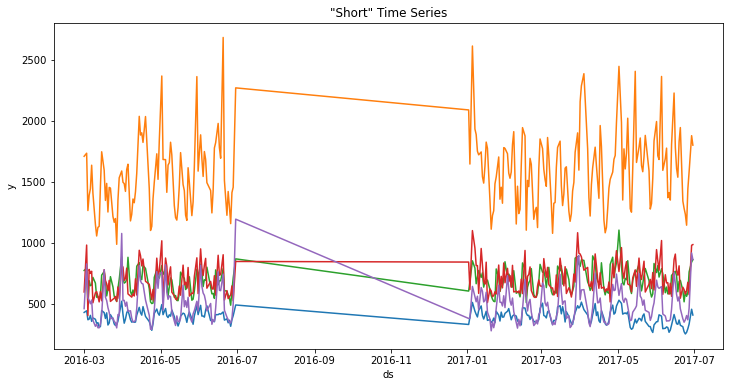

In [8]:
# some plots

plt.figure(figsize=(12, 6))
for ts in short_ts:
    sns.lineplot(data=df.loc[df['id']==ts], x='ds', y='y', palette='Blues')
plt.title('"Short" Time Series')


### Missing values imputation <a class="anchor" id="miss"></a>

Seems that TS have weekly seasonal component, almost no trend and some monthly changes within a year

#### Missing values characteristics

Thus, all of the stores have missing values of suppossively the following nature:
* days off on Monday for two first months of 2016 and on Tuesday for the rest of the time
* holidays with non-working days in April and May 
  
Also some stores have non working days in December and July, but not all of them. Five TS have a gap in data from 07 of 2016 until 01 of 2017.

#### General approach for imputation

In this task different methods/algorithms of TS forecasting were used and some of those models are sensitive not to dates but to the order of data. Because of that it's necessary to impute missing values. 

Unfortunately, Python does not have similar to R na_seadec functionality, so a simple approach for imputation of missing values with seasonality was used: weekly seasonality was calculated for each day of week within every store. 

In [9]:
df_seas_coef = df.groupby(['id', 'day'], as_index=False).agg('median')

for ts in range(20):
    tmp = df_seas_coef[df_seas_coef['id']==ts].copy()
    tmp['coef'] = tmp['y']/tmp['y'].mean()
    df_seas_coef = pd.merge(df_seas_coef, tmp, how='outer')

In [10]:
df = pd.merge(df, df_seas_coef[['id', 'day', 'coef']], how='left', on=['id', 'day'])
df = df[~df['coef'].isna()]
df['sunday'] = df['ds']-df['day'].apply(lambda x: datetime.timedelta(x)) 

df = pd.merge(df, 
              pd.DataFrame(df.groupby(['id', 'sunday'])['y'].mean()).rename(columns={'y':'y_mean'}).reset_index())

# weekly seasonality calculation
df['y_seas']= df['y'] 
df['y_seas'] = np.where(df['y_seas'].isna(), df['y_mean']*df['coef'], df['y_seas']).tolist()

# target with missing values
df['y_init'] = df['y'] 
df['y'] = df['y_seas'] 

#linear interpolation
df['y_lin'] = df['y'].interpolate(method='linear', axis=0)
df['y_lin'] = np.where(df['y_init'].isna(), df['y_lin']*df['coef'], df['y_init']).tolist()

# linear interpolation with seasonality 
df['y_lin_seas'] = df['y_lin']*df['coef']
df['y_lin_seas'] = np.where(df['y_init'].isna(), df['y_lin_seas']*df['coef'], df['y_init']).tolist()

# among seasonal, linear and linear-seasonal interpolation the best result shown was for the first one
df

,id,ds,y,day,mnth,coef,sunday,y_mean,y_seas,y_init,y_lin,y_lin_seas
0,0,2016-03-01,564.2,1,2016-03-01,0.682837,2016-02-29,884.780000,564.2,564.2,564.2,564.2
1,0,2016-03-03,1161.1,3,2016-03-01,1.231378,2016-02-29,884.780000,1161.1,1161.1,1161.1,1161.1
2,0,2016-03-04,1007.0,4,2016-03-01,1.128510,2016-02-29,884.780000,1007.0,1007.0,1007.0,1007.0
3,0,2016-03-05,804.5,5,2016-03-01,0.961146,2016-02-29,884.780000,804.5,804.5,804.5,804.5
4,0,2016-03-06,887.1,6,2016-03-01,1.030313,2016-02-29,884.780000,887.1,887.1,887.1,887.1
...,...,...,...,...,...,...,...,...,...,...,...,...
8335,19,2017-06-25,338.3,6,2017-06-01,0.968778,2017-06-19,364.733333,338.3,338.3,338.3,338.3
8336,19,2017-06-26,358.4,0,2017-06-01,0.937321,2017-06-26,501.425000,358.4,358.4,358.4,358.4
8337,19,2017-06-27,278.5,1,2017-06-01,0.622322,2017-06-26,501.425000,278.5,278.5,278.5,278.5
8338,19,2017-06-29,739.1,3,2017-06-01,1.299883,2017-06-26,501.425000,739.1,739.1,739.1,739.1


--- 

## Best model selection using time series cross-validation <a class="anchor" id="best"></a>


The first two models are sensitive not to dates but to the order of data while the last one takes into consideration information of dates and days of week. Because of that it's necessary to impute missing values at least for Holt-Winters and ARIMA models.

In this task we are going to use different methods of TS forecasting:
* Holt-Winters model with additive trend and seasonality: 
    * no tuning of parameters, seasonality supposed to be weekly (with cycle of 6 because Tuesday is always missing
    
    
* ARIMA model with auto tuning of parameters:
    * the order (or number of time lags) of the auto-regressive (“AR”) model **p** varies between 1 and 4
    * the order of the moving-average (“MA”) model **q** varies between 1 and 4
    * the order of the auto-regressive portion of the seasonal model **P** varies between 1 and 4
    * the order of the moving-average portion of the seasonal mode **Q** varies between 1 and 4
    * the maximum number of non-seasonal differences **d** varies between 1 and 4
    * the order of the seasonal differencing **D** varies between 1 and 5


* facebook Prophet model with tuning of:
    * seasonality_mode - additive and multiplicative
    * weekly_seasonality - witout weekly seasonality and with one using a Fourier order 2, 3, 5
    * monthly_seasonality - without and with using a Fourier order 2, 3
    * yearly_seasonality was set to false due to too short TS
    
For Prophet model the best set of parameters was choosen according to the sMAE metric value on three fold time series cross-validation. cross-validation for parameters selection is always performed only at train dataset.        
        

### "Complete" time series <a class="anchor" id="comp"></a>

The best model for forecasting "complete" time series (the majority of all TS, the ones that have data witout big interruptions) was choosen using three folds time series cross-validation with an algorithm of rolling window. Thus, for each of time series considered there was a forecast made for three independent time periods with duration of 31 day. 

In [11]:
def ts_metrics_all(ts_list, models_list, df, cv_folds=3, horizon=31):
    result = []
    for ts in tqdm(ts_list):    
        tmp = df.loc[(df['id']==ts)]
        for model in models_list:
            mean_smae, mean_mape, model_name = ts_cv_metrics(tmp, model, cv_folds=cv_folds, horizon=horizon)
            res = {'id': ts, 'model': model_name, 'smae': mean_smae, 'mape': mean_mape}
            result.append(res)
    return result

In [12]:
hw_model = WrapperHoltWinters()
arima_model = WrapperAutoArima()
prophet_model = WrapperProphet()
models = [hw_model, arima_model, prophet_model]

In [13]:
metrics_complete_ts = ts_metrics_all(complete_ts, models, df, cv_folds=5, horizon=31)
metrics_complete_ts = pd.DataFrame(metrics_complete_ts)
metrics_complete_ts

100%|███████████████████████████████████████████████████████████████████████████████| 15/15 [1:25:55<00:00, 343.71s/it]


,id,model,smae,mape
0,0,HoltWinters,0.195047,0.199159
1,0,AutoArima,0.178614,0.191724
2,0,Prophet,0.120531,0.123942
3,1,HoltWinters,0.188494,0.185614
4,1,AutoArima,0.163679,0.156482
5,1,Prophet,0.134649,0.136642
6,2,HoltWinters,0.167762,0.162852
7,2,AutoArima,0.136447,0.134170
8,2,Prophet,0.100451,0.100364
9,3,HoltWinters,0.314029,0.328993


### "Short" time series<a class="anchor" id="short"></a>

For incomplete time series the same approach as for the rest of data was used. The initial idea is that we can forecast using as a train sample only short part of a dataset, which is the closest to the forecasted period of time. Two fold cross-validation was used due to the length of the time series.

In [14]:
metrics_short_ts = ts_metrics_all(short_ts, models, df[df['ds']>=pd.to_datetime('2017-01-02')], cv_folds=2, horizon=31)
metrics_short_ts = pd.DataFrame(metrics_short_ts)
metrics_short_ts

100%|███████████████████████████████████████████████████████████████████████████████████| 5/5 [16:19<00:00, 195.82s/it]


,id,model,smae,mape
0,4,HoltWinters,0.205914,0.210225
1,4,AutoArima,0.179538,0.197524
2,4,Prophet,0.158933,0.173351
3,8,HoltWinters,0.163386,0.155376
4,8,AutoArima,0.143364,0.140614
5,8,Prophet,0.114609,0.116827
6,10,HoltWinters,0.183850,0.182685
7,10,AutoArima,0.112023,0.110992
8,10,Prophet,0.099079,0.103406
9,13,HoltWinters,0.126078,0.115859


## Forecasting and conclusions<a class="anchor" id="forecast"></a>

Thus, for all of the TS the best result according to the key performance metric sMAE is achieved using Prophet model from Facebook, even thoough in some of cases AutoArima was also giving good results. 

Pipeline used:
1. Descriptive analysis, discovery of days-off, holidays, missing values and even missing time periods. 
2. Missing values imputation using weekly seasonality, division of time series into two groups: complete time series with big amount of observations and short time series (25% of all TS) with missing period in 2016 year. 
2. Testing on time series cross-validation three different models: Holt-Winters, auto ARIMA and Prophet for two groups of time series.
3. Forecasting for 07 month of 2017 using the best model selected at the previous step: Prophet.  

In [16]:
prophet_model = WrapperProphet()
forecast_result = pd.DataFrame()
for ts in tqdm(np.unique(df['id'])):
    if ts in short_ts:
        tmp = df.loc[(df['id']==ts)&(df['ds'] >= pd.to_datetime('2017-01-02'))]
        cv=3
    else: 
        tmp = df.loc[df['id']==ts]
        cv=5
        
    prophet_model.fit(tmp, cv=cv)
    pred = prophet_model.predict(tmp, 31)
    pred['target'] = np.where(pred['ds'].dt.dayofweek == 2, 0, pred['yhat']).tolist()
    pred['id'] = ts
    pred = pred[['id', 'ds', 'target']]
    forecast_result = forecast_result.append(pred)
forecast_result = forecast_result.sort_values(['id', 'ds'])

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [33:07<00:00, 99.39s/it]


In [17]:
forecast_result

,id,ds,target
0,0,2017-07-01,834.933588
1,0,2017-07-02,937.668163
2,0,2017-07-03,892.186606
3,0,2017-07-04,668.670298
4,0,2017-07-05,0.000000
...,...,...,...
26,19,2017-07-27,495.439183
27,19,2017-07-28,468.554276
28,19,2017-07-29,451.819106
29,19,2017-07-30,467.826323


In [18]:
forecast_result.to_csv('predict.csv')